In [6]:
import sys
sys.executable


'/mnt/disk/Holberton/envs/docai-jup-env/bin/python'

In [ ]:
import sys
!{sys.executable} -m pip install craft-text-detector


In [7]:
!{sys.executable} -m pip install "numpy<2.0"


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.2/18.2 MB 3.5 MB/s  0:00:05 eta 0:00:010:00:01
  Attempting uninstall: numpy
    Found existing installation: numpy 2.0.2
    Uninstalling numpy-2.0.2:
      Successfully uninstalled numpy-2.0.2
  You can safely remove it manually.
  You can safely remove it manually.
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
ultralytics 8.3.242 requires opencv-python>=4.6.0, but you have opencv-python 4.5.4.60 which is incompatible.


In [ ]:
!pip install craft-text-detector

In [ ]:
!pip install ultralytics opencv-python pillow matplotlib
!pip install craft-text-detector
!pip install pdf2image


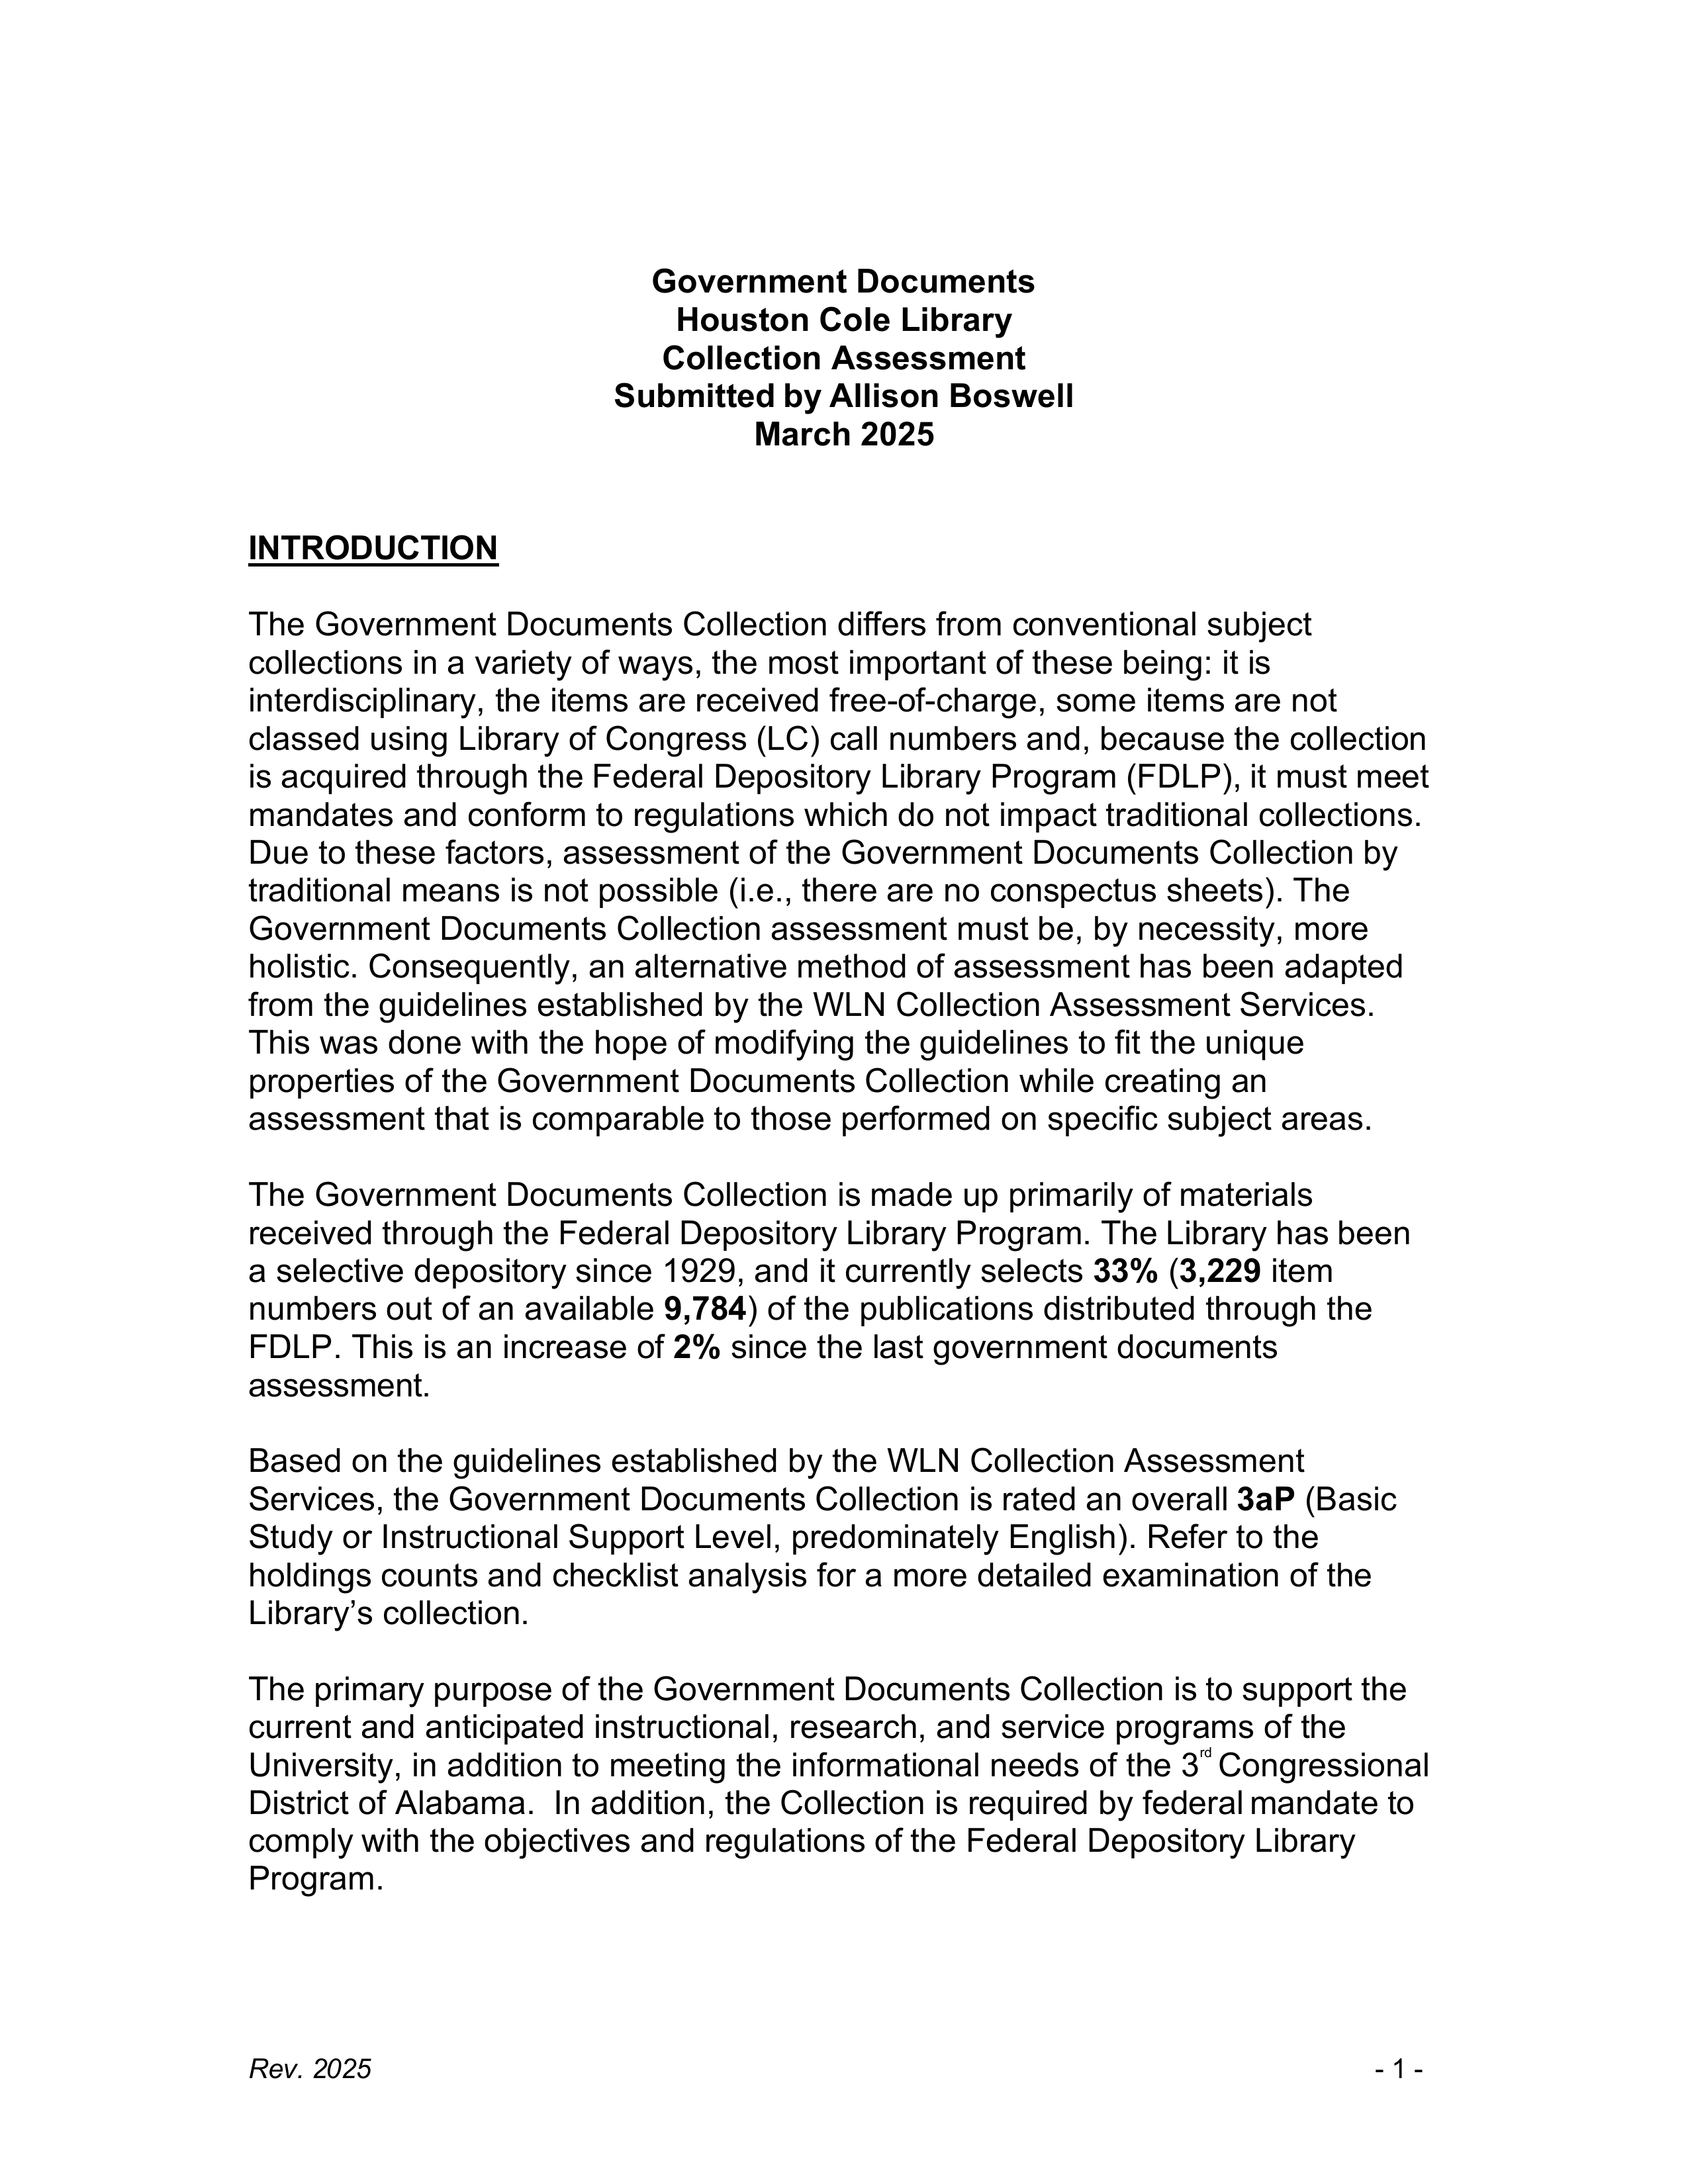

In [1]:
from pdf2image import convert_from_path
from PIL import Image

pdf_path = "/home/jordy4life/Downloads/GovernmentDocuments.pdf"
pages = convert_from_path(pdf_path, dpi=300)

img = pages[0]
img.save("page.png")

img


In [2]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def draw_boxes(img, boxes, color=(0,255,0), thickness=2):
    canvas = np.array(img).copy()
    for x0, y0, x1, y1 in boxes:
        cv2.rectangle(canvas, (int(x0),int(y0)), (int(x1),int(y1)), color, thickness)
    return canvas

def show(img, title):
    plt.figure(figsize=(10,14))
    plt.imshow(img)
    plt.title(title)
    plt.axis("off")
    plt.show()



image 1/1 /mnt/disk/Holberton/DocAI-API/analysis/page.png: 1280x992 254 texts, 772.6ms
Speed: 22.3ms preprocess, 772.6ms inference, 2.1ms postprocess per image at shape (1, 3, 1280, 992)


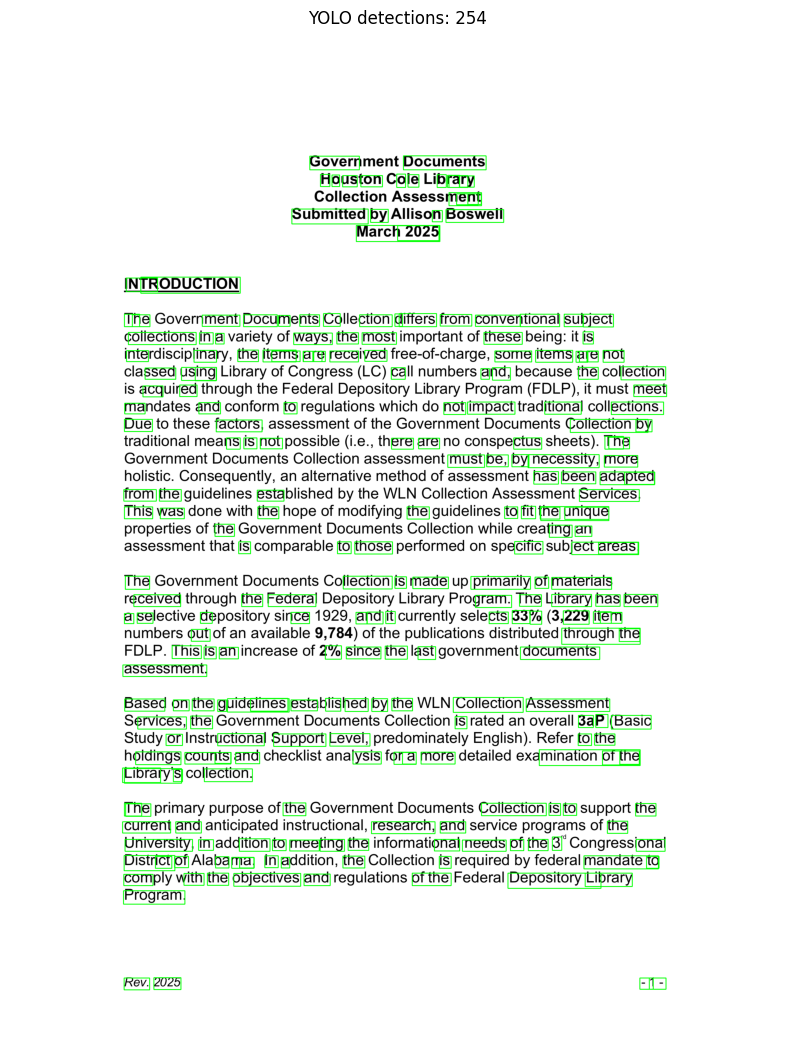

In [3]:
from ultralytics import YOLO

model = YOLO("/mnt/disk/Holberton/DocAI-API/models/yolov8/best_2.pt")

results = model(
    "page.png",
    imgsz=1280,
    conf=0.1,
    iou=0.6,
    device="cpu"  # comment if CUDA works
)

yolo_boxes = results[0].boxes.xyxy.cpu().numpy()

show(draw_boxes(img, yolo_boxes), f"YOLO detections: {len(yolo_boxes)}")


In [ ]:
from craft_text_detector import Craft

craft = Craft(output_dir="craft_out", crop_type="poly", cuda=False)

prediction = craft.detect_text("page.png")

craft_boxes = []
for poly in prediction["boxes"]:
    xs = poly[:, 0]
    ys = poly[:, 1]
    craft_boxes.append([xs.min(), ys.min(), xs.max(), ys.max()])

show(draw_boxes(img, craft_boxes), f"CRAFT detections: {len(craft_boxes)}")

craft.unload_craftnet_model()
craft.unload_refinenet_model()


In [ ]:
import easyocr

reader = easyocr.Reader(
    ['en'],        # language does NOT matter for detection
    gpu=False
)

results = reader.readtext(
    "page.png",
    detail=1,
    paragraph=False
)

easy_boxes = []
for r in results:
    poly = r[0]
    xs = [p[0] for p in poly]
    ys = [p[1] for p in poly]
    easy_boxes.append([min(xs), min(ys), max(xs), max(ys)])

show(draw_boxes(img, easy_boxes), f"EasyOCR detections: {len(easy_boxes)}")


In [ ]:
print("YOLO boxes   :", len(yolo_boxes))
print("CRAFT boxes  :", len(craft_boxes))
print("EasyOCR boxes:", len(easy_boxes))
